In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
PATH = "/m/cs/work/luongn1/digirhythm/data/processed/momo/similarity_matrix/"

# List all files in the directory
all_files = os.listdir(PATH)
print(all_files)

# Save a palette to a variable:
palette = sns.color_palette("bright")

sns.set_palette(palette)

['similarity_HDpA00dUifZ5.csv', 'similarity_4U-z2a8-4LfC.csv', 'similarity_RO9MDopzUfHo.csv', 'similarity_EcDBPfOd-tji.csv', 'similarity_SATFc0U1XHrJ.csv', 'similarity_75wfB613llIF.csv', 'similarity_wxzd30CsS09m.csv', 'similarity_U5cKPUTMu0fs.csv', 'similarity_C16oRDnCUik-.csv', 'similarity_oItkDMGyE_uL.csv', 'similarity_W6WhLTeFA3RT.csv', 'similarity_MNOjIfAeZSV4.csv', 'similarity_c92RUDpQdRsV.csv', 'similarity_T2iKQFAiXP15.csv', 'similarity_-N2FwY4uC3d7.csv', 'similarity_bOSChw4Ipatb.csv', 'similarity_rkFen2Hs6Lbo.csv', 'similarity_dn-ArUl4FIUe.csv', 'similarity_5U61OcE1cgW_.csv', 'similarity_J1cfSjiD0iD9.csv', 'similarity_epAx1MybHBcL.csv', 'similarity_2NtvG4WqOd1S.csv', 'similarity_IZr3eFPWcYod.csv', 'similarity_qOGaFEyNVUMh.csv', 'similarity_7kH-L_CWn-kl.csv', 'similarity_SK80lPsgpYX3.csv', 'similarity_3noC1OdWbTjA.csv', 'similarity_Gq5JcPdzhkpL.csv', 'similarity_7ov4Ahb_Kg1n.csv', 'similarity_PuVT9SuHD_RF.csv', 'similarity_5DWiLmu6c6u7.csv', 'similarity_0xpBKXpjmT2Z.csv', 'simila

In [37]:
# Take a sample
sample = pd.read_csv(PATH + "similarity_bOSChw4Ipatb.csv", index_col=0)

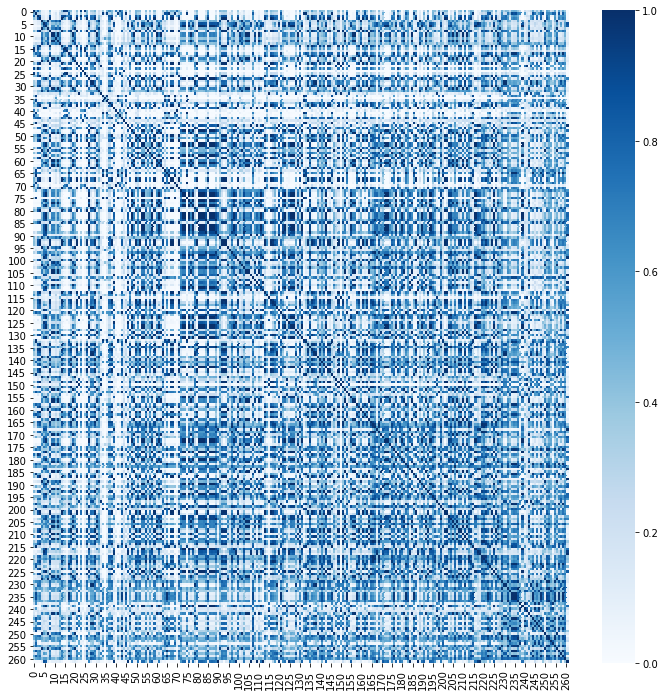

In [38]:
def recurrent_plot(df):
    # Viz
    sns.heatmap(df, cmap="Blues")

plt.figure(figsize=(12,12))
recurrent_plot(sample)

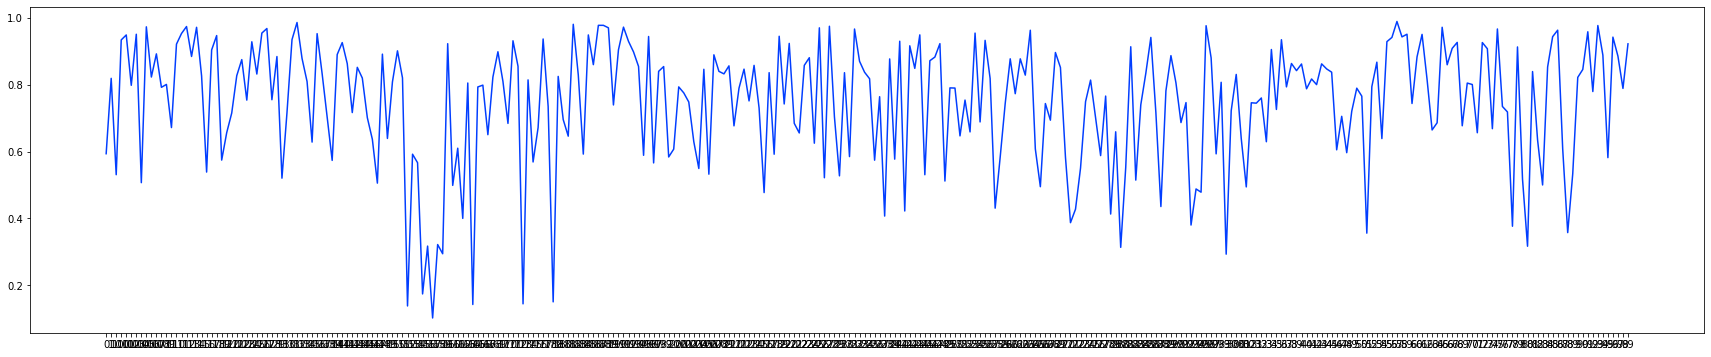

In [40]:
similarity_baseline = pd.read_csv(PATH + "similarity_baseline.csv", index_col=0)
s = similarity_baseline.loc['0xpBKXpjmT2Z'].dropna()


plt.figure(figsize=(30,6))
sns.lineplot(x=s.index, y=s.values)


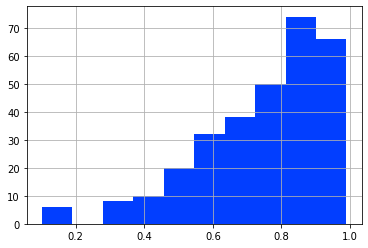

In [43]:
s.hist()